In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sc = pd.read_csv("/content/sentiment_cleaned.csv")
dc = pd.read_csv("/content/data_cleaned.csv")

/tmp/ipython-input-1579253901.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  mergeddf = pd.read_csv("/content/merged_trades_sentiment.csv")


EDA (studying independent cleaned data first)

In [4]:
print("Shape:", sc.shape)
print("\nDtypes:\n", sc.dtypes)

Shape: (2644, 9)

Dtypes:
 timestamp          int64
value              int64
classification    object
date              object
sent_dt_unix_s    object
sent_dt_str       object
sent_dt           object
date_gran         object
date_key          object
dtype: object


In [5]:
if 'date' in sc.columns:
    sc['date'] = pd.to_datetime(sc['date'], errors='coerce')
else:
    # try fallback keys
    if 'date_key' in sc.columns:
        sc['date'] = pd.to_datetime(sc['date_key'], errors='coerce')
    else:
        raise ValueError("No 'date' or 'date_key' column found in sentiment_cleaned.csv")

print("\nDate range:", sc['date'].min(), "->", sc['date'].max())


Date range: 2018-02-01 00:00:00 -> 2025-05-02 00:00:00


In [6]:
if 'value' in sc.columns:
    print("\nValue stats:\n", sc['value'].describe())
else:
    raise ValueError("No 'value' column found in sentiment_cleaned.csv")


Value stats:
 count    2644.000000
mean       46.981089
std        21.827680
min         5.000000
25%        28.000000
50%        46.000000
75%        66.000000
max        95.000000
Name: value, dtype: float64


In [7]:
if 'classification' in sc.columns:
    print("\nClassification counts:\n", sc['classification'].value_counts(dropna=False))
else:
    print("\nNo 'classification' column found — skipping counts.")


Classification counts:
 classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [8]:
sc_ts = sc.set_index('date').sort_index()
sc_ts = sc_ts[~sc_ts.index.duplicated(keep='first')]

In [9]:
# Rolling statistics (window = 7 days)
sc_ts['value_roll7'] = sc_ts['value'].rolling(window=7, min_periods=1).mean()
sc_ts['value_roll21'] = sc_ts['value'].rolling(window=21, min_periods=1).mean()
sc_ts['value_vol21'] = sc_ts['value'].rolling(window=21, min_periods=1).std()

In [10]:
print("\nSample (last 5) of value, 7d & 21d rolling means, 21d vol:")
print(sc_ts[['value','value_roll7','value_roll21','value_vol21']].tail())


Sample (last 5) of value, 7d & 21d rolling means, 21d vol:
            value  value_roll7  value_roll21  value_vol21
date                                                     
2025-04-28     54    60.285714     42.142857    15.160098
2025-04-29     60    62.142857     43.857143    15.040897
2025-04-30     56    59.857143     45.666667    14.026166
2025-05-01     53    58.428571     46.333333    14.026166
2025-05-02     67    59.428571     48.333333    13.825098


In [11]:
autocorr_lag1 = sc_ts['value'].autocorr(lag=1)
print("\nAutocorrelation (lag=1) of value:", autocorr_lag1)


Autocorrelation (lag=1) of value: 0.9549313266640433


In [12]:
# Transitions- how often classification changes from one day to next
if 'classification' in sc_ts.columns:
    sc_ts['class_shift'] = sc_ts['classification'].shift(1)
    transitions = (sc_ts['classification'] != sc_ts['class_shift']).sum()
    total_days = len(sc_ts)
    print(f"\nClassification transitions: {transitions} changes over {total_days} days (fraction = {transitions/total_days:.3f})")
    # contingency: count transitions matrix (previous -> current)
    trans_matrix = pd.crosstab(sc_ts['class_shift'].fillna('NA'), sc_ts['classification'])
    print("\nTransition matrix (prev -> curr):\n", trans_matrix)
else:
    print("\nNo 'classification' column — skipping transitions.")


Classification transitions: 595 changes over 2644 days (fraction = 0.225)

Transition matrix (prev -> curr):
 classification  Extreme Fear  Extreme Greed  Fear  Greed  Neutral
class_shift                                                      
Extreme Fear             416              0    88      0        4
Extreme Greed              0            271     2     52        1
Fear                      88              1   610     12       70
Greed                      1             54    12    498       67
NA                         0              0     1      0        0
Neutral                    3              0    68     71      254


In [13]:
#plots

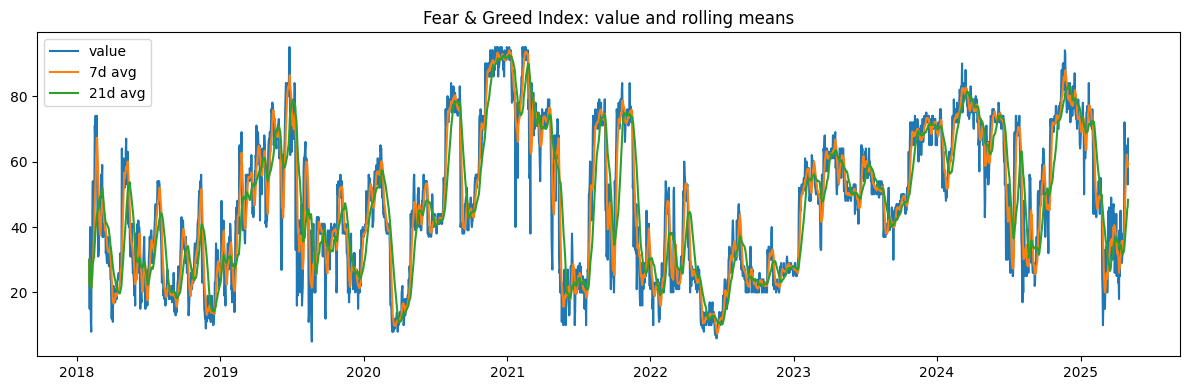

In [14]:
plt.figure(figsize=(12,4))
plt.plot(sc_ts.index, sc_ts['value'], label='value')
plt.plot(sc_ts.index, sc_ts['value_roll7'], label='7d avg')
plt.plot(sc_ts.index, sc_ts['value_roll21'], label='21d avg')
plt.title('Fear & Greed Index: value and rolling means')
plt.legend()
plt.tight_layout()
plt.show()

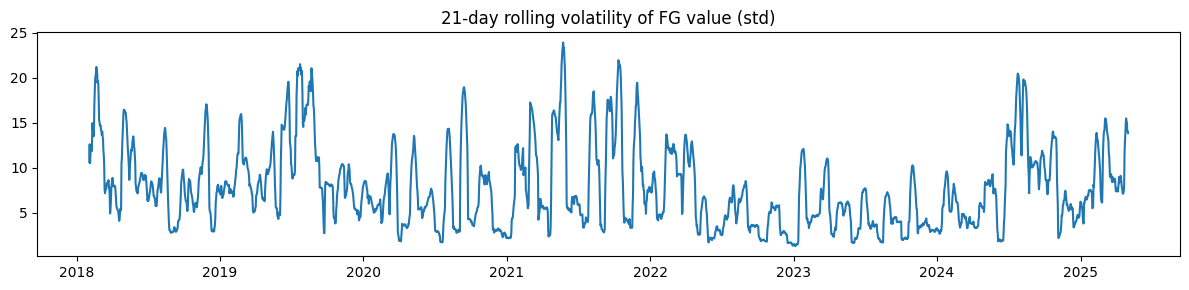

In [15]:
plt.figure(figsize=(12,3))
plt.plot(sc_ts.index, sc_ts['value_vol21'])
plt.title('21-day rolling volatility of FG value (std)')
plt.tight_layout()
plt.show()

In [16]:
print("Shape:", dc.shape)
print("\nColumns:\n", dc.columns.tolist())

Shape: (7050, 30)

Columns:
 ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'trade_dt_epoch_ms', 'trade_dt_epoch_s', 'trade_dt_ist', 'trade_dt_fallback', 'trade_dt', 'date_gran', 'date_key', 'diff_days_ms_vs_ist', 'diff_days_s_vs_ist', 'trade_dt_epoch_best', 'trade_dt_ist_local', 'trade_dt_utc', 'date_key_utc', 'date_key_ist']


In [17]:
print("\nDtypes summary:\n", dc.dtypes.value_counts())


Dtypes summary:
 object     17
float64    13
Name: count, dtype: int64


In [18]:
datetime_cols = [c for c in dc.columns if 'date' in c.lower() or 'time' in c.lower()]
print("\nDetected datetime-related columns:", datetime_cols[:5])


Detected datetime-related columns: ['Timestamp IST', 'Timestamp', 'date_gran', 'date_key', 'date_key_utc']


In [19]:
if 'trade_dt' in dc.columns:
    dc['trade_dt'] = pd.to_datetime(dc['trade_dt'], errors='coerce')
elif 'Timestamp IST' in dc.columns:
    dc['trade_dt'] = pd.to_datetime(dc['Timestamp IST'], dayfirst=True, errors='coerce')
elif 'Timestamp' in dc.columns:
    dc['trade_dt'] = pd.to_datetime(dc['Timestamp'], unit='ms', errors='coerce')

In [20]:
print("\nDate range:", dc['trade_dt'].min(), "->", dc['trade_dt'].max())


Date range: 2024-09-20 14:06:00+05:30 -> 2025-04-25 13:39:00+05:30


In [21]:
num_cols = ['Execution Price', 'Size USD', 'Closed PnL', 'Fee']
num_cols = [c for c in num_cols if c in dc.columns]

In [22]:
print("\nSummary statistics for numeric columns:\n")
print(dc[num_cols].describe().T)


Summary statistics for numeric columns:

                  count          mean           std           min         25%  \
Execution Price  7050.0  40616.715212  41715.892162      0.007412   17.085000   
Size USD         7050.0  17657.315617  81047.398143      0.100000  261.650000   
Closed PnL       7050.0    114.884545    981.195734 -29370.119800    0.000000   
Fee              7049.0      3.155138     12.285295      0.000000    0.007884   

                         50%           75%           max  
Execution Price   254.800000  83607.000000  8.568700e+04  
Size USD         1132.165000   7054.350000  3.509753e+06  
Closed PnL          0.000000      9.105755  2.722374e+04  
Fee                 0.130208      1.041723  3.475057e+02  


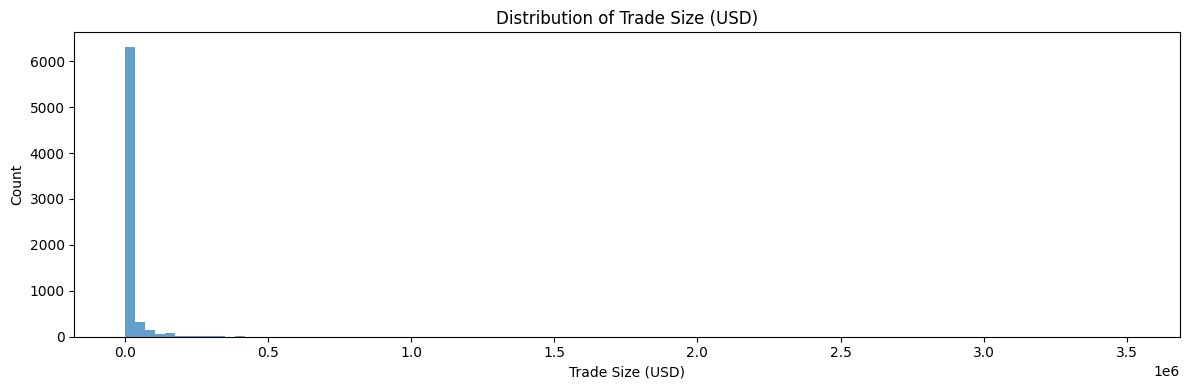

In [23]:
plt.figure(figsize=(12,4))
plt.hist(dc['Size USD'], bins=100, alpha=0.7)
plt.title('Distribution of Trade Size (USD)')
plt.xlabel('Trade Size (USD)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

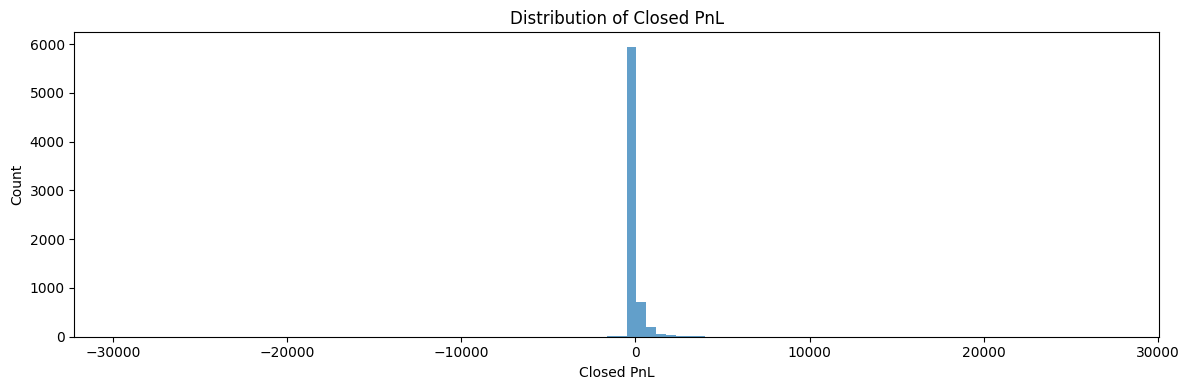

In [24]:
plt.figure(figsize=(12,4))
plt.hist(dc['Closed PnL'], bins=100, alpha=0.7)
plt.title('Distribution of Closed PnL')
plt.xlabel('Closed PnL')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [25]:
dc['date_key'] = dc['trade_dt'].dt.strftime('%Y-%m-%d')
daily = dc.groupby('date_key', as_index=False).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Fee': 'sum'
})

print("\nDaily aggregated sample:\n", daily.head())


Daily aggregated sample:
      date_key  Closed PnL  Size USD       Fee
0  2024-09-20         0.0  28301.77  2.716968
1  2024-09-24         0.0   6113.57  0.586902
2  2024-09-25         0.0   2753.02  0.264289
3  2024-09-26         0.0  33271.51  3.194060
4  2024-09-27         0.0  26104.72  2.506004


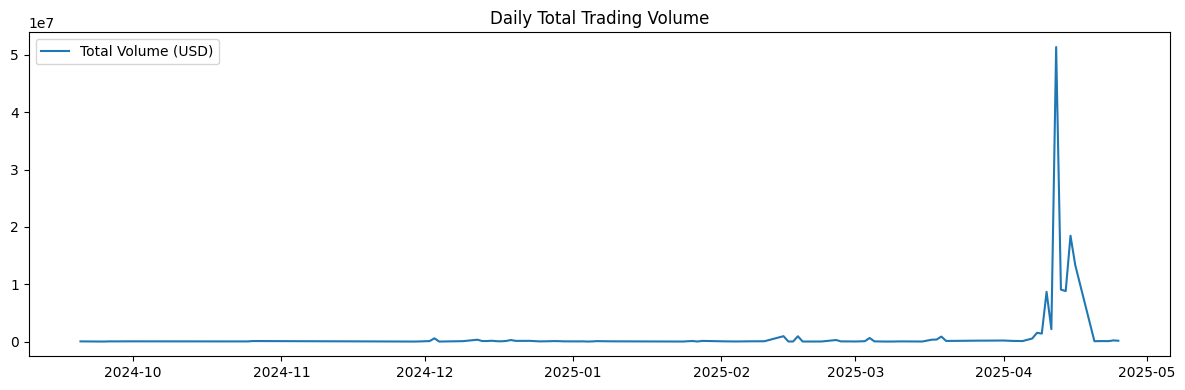

In [26]:
plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(daily['date_key']), daily['Size USD'], label='Total Volume (USD)')
plt.title('Daily Total Trading Volume')
plt.legend()
plt.tight_layout()
plt.show()

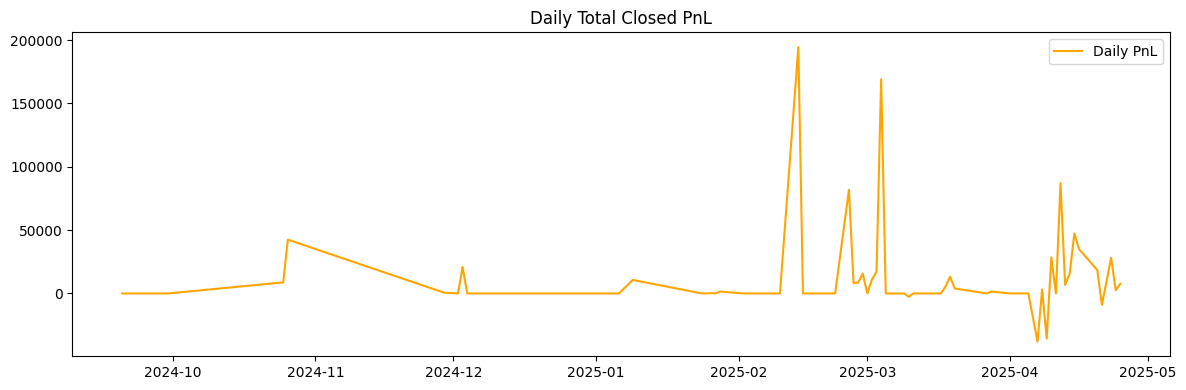

In [27]:
plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(daily['date_key']), daily['Closed PnL'], label='Daily PnL', color='orange')
plt.title('Daily Total Closed PnL')
plt.legend()
plt.tight_layout()
plt.show()